In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from statistics import mean

In [5]:
df = pd.read_csv('first_100_labels.csv')
df = df.drop(columns=df.columns[0])

In [6]:
df

,ID,0:00:00,0:00:05,0:00:10,0:00:15,0:00:20,0:00:25,0:00:30,0:00:35,0:00:40,...,0:59:30,0:59:35,0:59:40,0:59:45,0:59:50,0:59:55,1:00:00,1:00:05,1:00:10,label
0,2,0.543,0.543,0.545,0.551,0.542,0.538,0.553,0.537,0.548,...,0.608,0.591,0.603,0.605,0.598,0.595,0.599,0.605,0.614,0
1,3,0.618,0.629,0.625,0.624,0.615,0.608,0.630,0.628,0.620,...,0.646,0.628,0.638,0.647,0.628,0.633,0.628,0.636,0.632,0
2,4,0.566,0.587,0.576,0.579,0.573,0.577,0.582,0.576,0.577,...,0.580,0.592,0.609,0.586,0.567,0.572,0.574,0.575,0.576,0
3,6,0.635,0.646,0.631,0.636,0.631,0.603,0.633,0.632,0.629,...,0.593,0.589,0.583,0.585,0.612,0.608,0.585,0.613,0.594,0
4,7,0.626,0.626,0.602,0.612,0.623,0.609,0.626,0.614,0.611,...,0.670,0.698,0.692,0.713,0.782,0.817,0.796,0.764,0.712,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,115,0.580,0.593,0.594,0.583,0.578,0.578,0.609,0.596,0.605,...,0.772,0.743,0.773,0.791,0.789,0.746,0.768,0.796,0.819,0
96,116,0.597,0.621,0.606,0.616,0.599,0.603,0.615,0.616,0.615,...,0.590,0.587,0.580,0.589,0.581,0.593,0.579,0.596,0.595,0
97,117,0.620,0.650,0.617,0.615,0.621,0.595,0.642,0.626,0.634,...,0.624,0.618,0.611,0.616,0.629,0.603,0.616,0.621,0.625,1
98,120,0.609,0.629,0.612,0.610,0.606,0.621,0.637,0.607,0.607,...,0.604,0.581,0.601,0.601,0.584,0.570,0.580,0.578,0.591,0


In [57]:
# functions

def calc_ma(array, size): # function to calculate cumulative moving averages for an array
    
    # Convert array of integers to pandas series
    numbers_series = pd.Series(array)

    # Get the window of series of observations of specified window size
    windows = numbers_series.rolling(size)

    # Create a series of moving
    # averages of each window
    moving_averages = windows.mean()

    # Convert pandas series back to list
    moving_averages_list = moving_averages.tolist()

    return moving_averages_list


def find_ma_spikes(roi_array, ma_array, std_threshold=0.5):
    
    cum_ma = calc_cum_ma(roi_array)
    std = np.std(roi_array) * std_threshold
    threshold = [i + std for i in cum_ma]
    
    spike_starts = list()
    spike_ends = list()

    in_spike = False
    for i in range(len(ma_array)):
        if ma_array[i] >= threshold[i] and ma_array[i-1] < threshold[i] and in_spike == False:
            spike_starts.append(i-2)
            in_spike = True
        if ma_array[i] <= threshold[i] and ma_array[i-1] > threshold[i] and in_spike == True:
            spike_ends.append(i)
            in_spike = False
    
    # if a spike starts and continues until the end of the frame, we'll just consider the final index - 1 as the end
    if len(spike_starts) > len(spike_ends):
        spike_ends.append(int(len(ma_array) - 1))
    return spike_starts, spike_ends, threshold


def calc_cum_ma(array): # function to calculate cumulative moving averages for an array
    
    moving_averages = list()
    cum_sum = np.cumsum(array)
    
    i = 1    
    while i <= len(array):

        window_average = round(cum_sum[i-1] / i, 3)
        moving_averages.append(window_average)

        i += 1
    return moving_averages


def calc_integral(spike, cum_ma):
    floor = cum_ma[i]
    norm_spike = [round(point - floor, 3) for point in spike]
    integral = np.trapz(norm_spike)
    return integral


def plot_ma_spikes(roi_id, ma_size=20, std_ratio=0.5, plot=True, return_=False):
    # this function will calculate and plot spikes found using the following definition:
    # spike begins when MA20 crosses 0.5 standard deviations above the cumulative moving average
    
    roi = list(df.iloc[roi_id])[1:]
    roi_ma = calc_ma(roi, size=ma_size)
    
    starts, ends, threshold = find_ma_spikes(roi, roi_ma, std_threshold=std_ratio)
    
    if plot:
        plt.figure(figsize=(10,5))
        plt.plot(roi)
        plt.plot(roi_ma, color='k')
        plt.plot(threshold, color='y')
        
        for i in range(len(starts)):
            plt.axvline(x=starts[i], color='goldenrod', linestyle='dashdot')
            plt.axvline(x=ends[i], color='goldenrod', linestyle='dashdot')
    
    if return_:
        return starts, ends, roi

In [9]:
res = list()

for row in range(len(df)):
    roi = list(df.iloc[row].values)[1:]
    roi_ma = calc_ma(roi, size=15)

    # use the new ma
    starts, ends, threshold = find_ma_spikes(roi, roi_ma, std_threshold=0.4)
    roi_cum_ma = calc_cum_ma(roi)

    durations = [ends[i] - starts[i] for i in range(len(ends))]
    heights = []
    means = []
    integrals = []


    if len(starts) > 0:
        for i in range(len(starts)):
            spike = roi[starts[i]-1:ends[i]+1]
            
            height = max(spike)   
            heights.append(height)
            
            mean_ = round(mean(spike), 3)
            means.append(mean_)
            
            integral = calc_integral(spike, roi_cum_ma)
            integrals.append(integral)
            
        parameters = [mean(roi), len(starts), mean(integrals), mean(durations), mean(heights), mean(means)]
        res.append(parameters)
        
    elif len(starts) == 0:
        parameters = [mean(roi), len(starts), 0, 0, 0, 0]
        res.append(parameters)


res_columns = ['ROI mean', 'Num. spikes', 'Mean Spike Integral', 'Mean spike duration', 'Mean spike height', 'Mean spike mean']
res_df = pd.DataFrame(res, columns = res_columns)


In [11]:
res_df['label'] = df['label']

In [12]:
res_df

,ROI mean,Num. spikes,Mean Spike Integral,Mean spike duration,Mean spike height,Mean spike mean,label
0,0.552164,2,4.196000,112.000000,0.595500,0.572500,0
1,0.619141,10,0.283100,35.300000,0.641500,0.625400,0
2,0.563742,15,-0.055033,18.666667,0.590133,0.570733,0
3,0.547960,1,-13.934500,271.000000,0.674000,0.583000,0
4,0.624149,1,8.875500,366.000000,1.000000,0.651000,1
...,...,...,...,...,...,...,...
95,0.639409,15,1.682267,16.533333,0.886533,0.683333,0
96,0.588097,0,0.000000,0.000000,0.000000,0.000000,0
97,0.596939,8,-0.212875,15.500000,0.666875,0.605125,1
98,0.609718,3,0.535833,24.666667,0.752667,0.637000,0


In [16]:
res_df_filtered = res_df[res_df['label'] != 0]
res_df_filtered

,ROI mean,Num. spikes,Mean Spike Integral,Mean spike duration,Mean spike height,Mean spike mean,label
4,0.624149,1,8.875500,366.000000,1.000000,0.651000,1
8,0.629463,10,0.148250,13.900000,0.904700,0.665400,1
9,0.640273,5,2.325400,21.600000,1.450000,0.835000,4
10,0.574564,7,-0.307286,12.142857,0.679857,0.588429,1
14,0.657573,7,0.516143,33.428571,0.748571,0.677286,1
15,0.697304,6,6.216500,51.166667,1.048833,0.740000,2
16,0.623046,2,1.996250,22.500000,1.421000,0.819000,2
18,0.595137,2,2.087000,22.000000,1.411000,0.817000,2
20,0.595715,4,1.667750,25.000000,0.946250,0.668500,1
21,0.697340,10,5.321550,24.900000,1.168000,0.819500,2


<AxesSubplot:xlabel='Num. spikes', ylabel='Mean spike duration'>

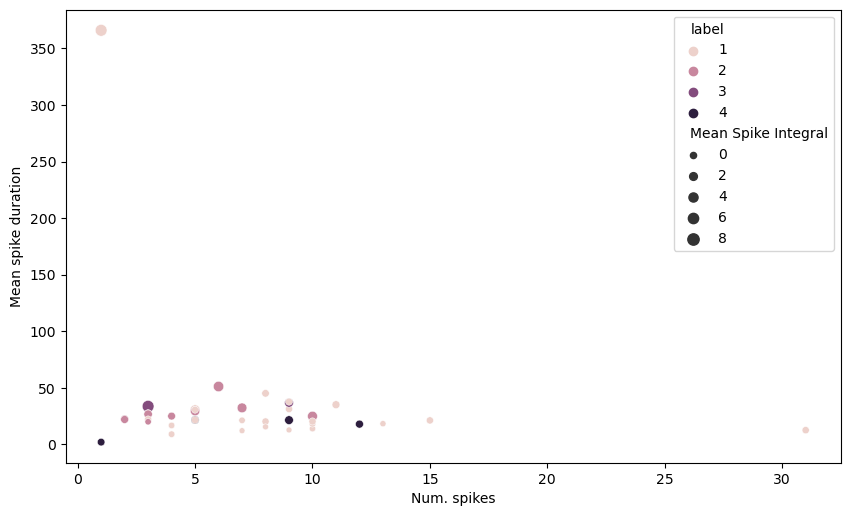

In [20]:
plt.figure(figsize=(10,6), dpi=100)

sns.scatterplot(data=res_df_filtered, x='Num. spikes', y='Mean spike duration', size='Mean Spike Integral', hue='label')



In [22]:
res_df[res_df['label'] == 0].describe()

,ROI mean,Num. spikes,Mean Spike Integral,Mean spike duration,Mean spike height,Mean spike mean,label
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.0
mean,0.590604,5.716667,0.477770,35.355017,0.473931,0.442746,0.0
std,0.030608,5.842833,2.543187,59.324906,0.293919,0.270883,0.0
min,0.526776,0.000000,-13.934500,0.000000,0.000000,0.000000,0.0
25%,0.573725,0.000000,-0.012937,0.000000,0.000000,0.000000,0.0
50%,0.587281,4.500000,0.000000,16.630303,0.611027,0.585443,0.0
75%,0.608147,9.250000,0.547525,33.575000,0.643679,0.611600,0.0
max,0.673939,23.000000,9.697000,331.000000,0.886533,0.691500,0.0


In [23]:
res_df[res_df['label'] == 1].describe()

,ROI mean,Num. spikes,Mean Spike Integral,Mean spike duration,Mean spike height,Mean spike mean,label
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.0
mean,0.604668,8.458333,1.297904,37.114132,0.794831,0.639047,1.0
std,0.035171,5.800893,1.957064,70.646430,0.122068,0.043600,0.0
min,0.495805,1.000000,-0.307286,9.000000,0.637556,0.518889,1.0
25%,0.588817,5.000000,0.331018,16.437500,0.687233,0.605954,1.0
50%,0.603166,8.000000,1.051139,21.242857,0.764655,0.646643,1.0
75%,0.625478,10.000000,1.219771,30.755556,0.899554,0.669500,1.0
max,0.660851,31.000000,8.875500,366.000000,1.010400,0.694032,1.0


In [24]:
res_df[res_df['label'] == 2].describe()

,ROI mean,Num. spikes,Mean Spike Integral,Mean spike duration,Mean spike height,Mean spike mean,label
count,10.000000,10.00000,10.000000,10.000000,10.000000,10.000000,10.0
mean,0.634669,4.50000,3.075000,28.158571,1.195276,0.784242,2.0
std,0.041118,2.54951,2.007573,8.866411,0.132843,0.031626,0.0
min,0.591366,2.00000,0.223833,20.000000,1.037714,0.734667,2.0
25%,0.596562,3.00000,1.959594,23.100000,1.126267,0.761854,2.0
50%,0.633898,3.50000,2.489667,25.833333,1.169167,0.790167,2.0
75%,0.655719,5.75000,4.796593,28.966667,1.240438,0.811500,2.0
max,0.697340,10.00000,6.216500,51.166667,1.421000,0.819500,2.0


In [25]:
res_df[res_df['label'] == 3].describe()

,ROI mean,Num. spikes,Mean Spike Integral,Mean spike duration,Mean spike height,Mean spike mean,label
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.0
mean,0.700818,6.000000,6.251583,35.222222,1.341111,0.841500,3.0
std,0.110812,4.242641,3.748962,2.199888,0.543372,0.165699,0.0
min,0.622463,3.000000,3.600667,33.666667,0.956889,0.724333,3.0
25%,0.661641,4.500000,4.926125,34.444444,1.149000,0.782917,3.0
50%,0.700818,6.000000,6.251583,35.222222,1.341111,0.841500,3.0
75%,0.739996,7.500000,7.577042,36.000000,1.533222,0.900083,3.0
max,0.779174,9.000000,8.902500,36.777778,1.725333,0.958667,3.0


In [32]:
df.iloc[10].values

array([13.   ,  0.617,  0.623,  0.601,  0.608,  0.617,  0.603,  0.622,
        0.612,  0.612,  0.624,  0.603,  0.593,  0.599,  0.601,  0.604,
        0.583,  0.589,  0.577,  0.575,  0.57 ,  0.588,  0.581,  0.569,
        0.595,  0.596,  0.578,  0.589,  0.593,  0.651,  0.613,  0.585,
        0.583,  0.596,  0.574,  0.568,  0.581,  0.58 ,  0.584,  0.565,
        0.586,  0.58 ,  0.574,  0.57 ,  0.576,  0.574,  0.573,  0.593,
        0.584,  0.574,  0.57 ,  0.572,  0.587,  0.585,  0.559,  0.574,
        0.589,  0.596,  0.609,  0.6  ,  0.585,  0.567,  0.561,  0.568,
        0.575,  0.574,  0.583,  0.598,  0.581,  0.58 ,  0.588,  0.578,
        0.563,  0.568,  0.586,  0.571,  0.568,  0.566,  0.57 ,  0.573,
        0.571,  0.583,  0.576,  0.572,  0.575,  0.579,  0.579,  0.584,
        0.57 ,  0.573,  0.583,  0.571,  0.556,  0.568,  0.58 ,  0.551,
        0.557,  0.548,  0.57 ,  0.581,  0.558,  0.568,  0.588,  0.572,
        0.564,  0.559,  0.573,  0.572,  0.561,  0.573,  0.569,  0.569,
      

In [38]:
df.iloc[4]['label']

1.0

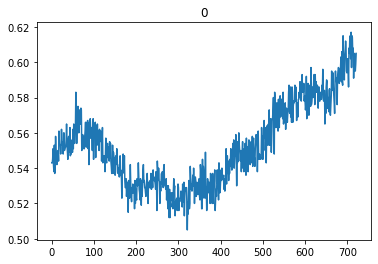

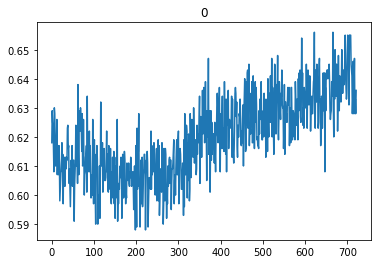

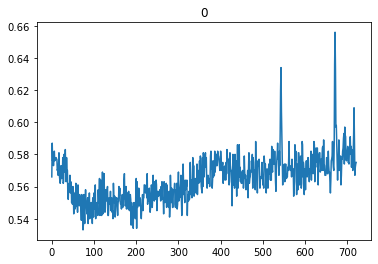

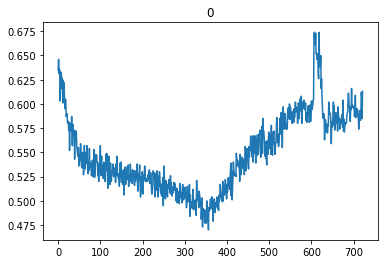

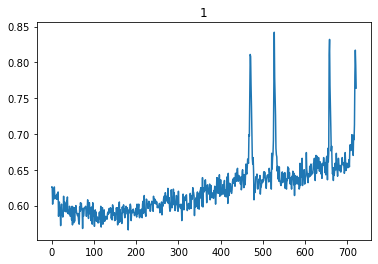

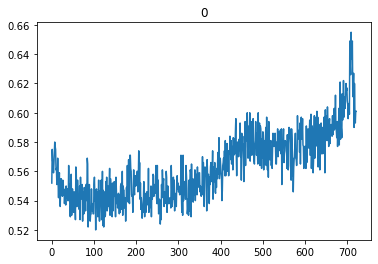

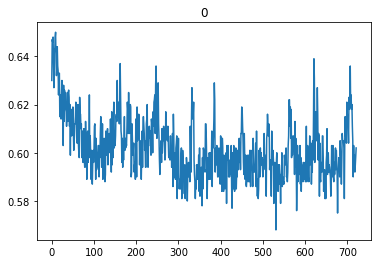

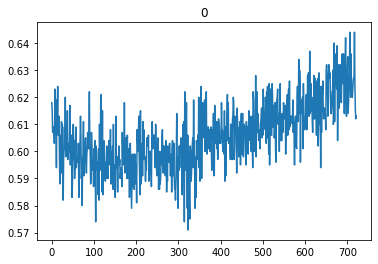

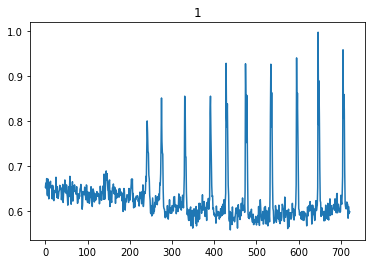

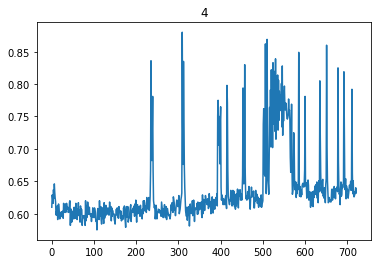

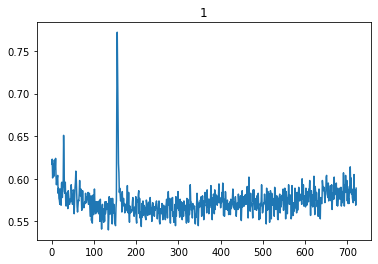

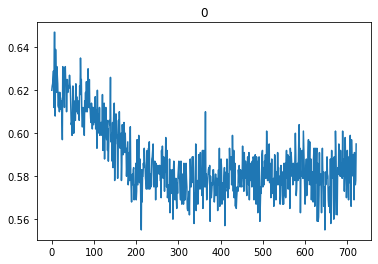

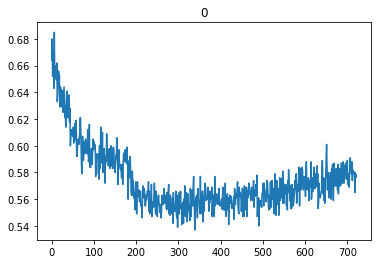

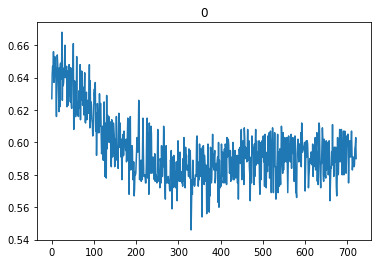

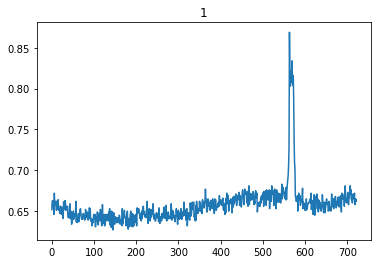

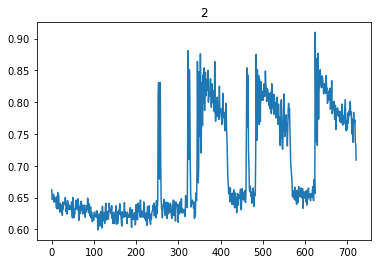

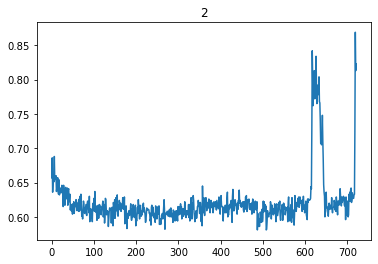

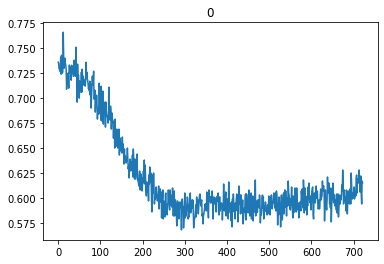

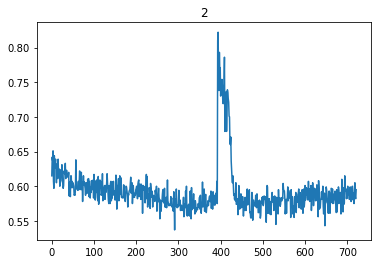

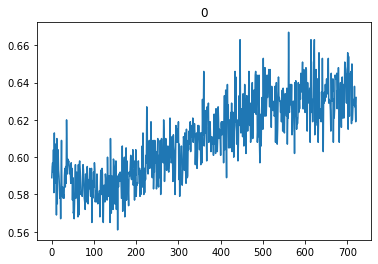

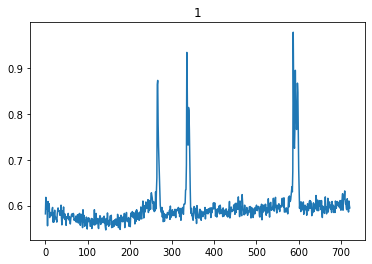

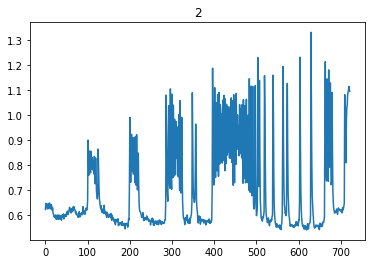

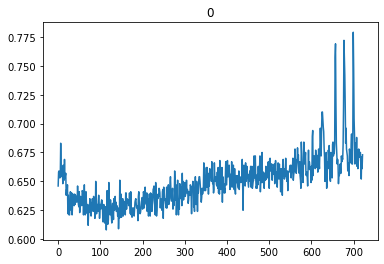

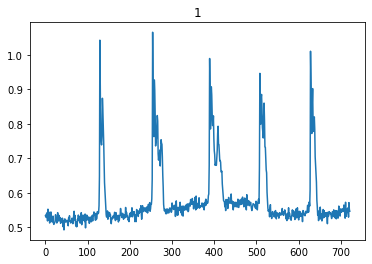

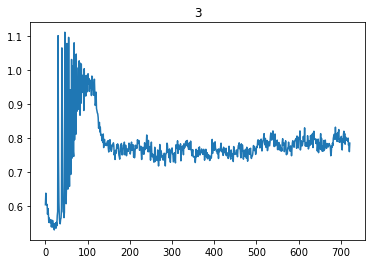

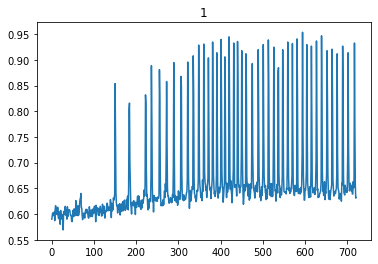

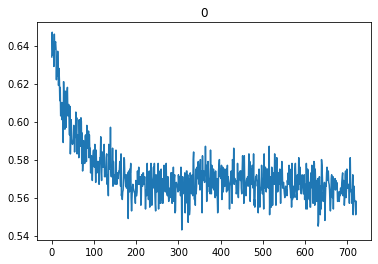

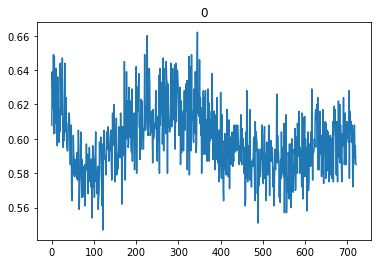

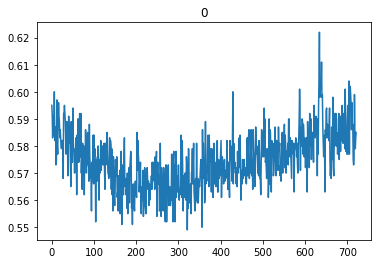

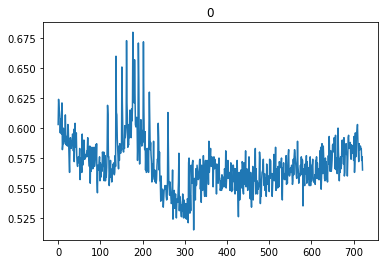

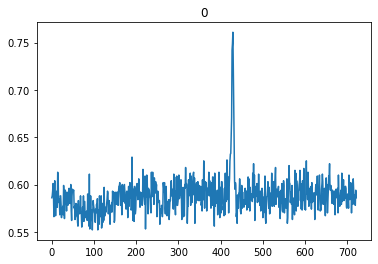

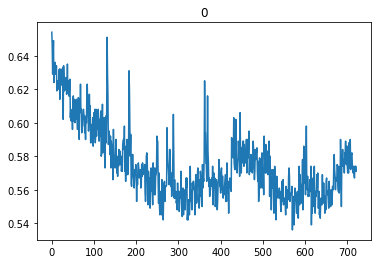

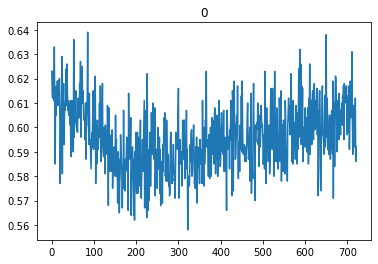

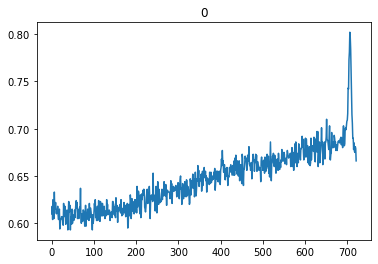

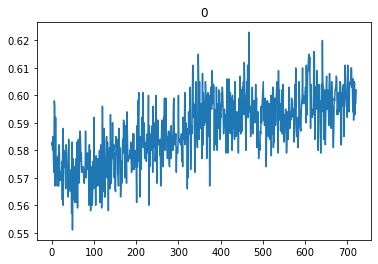

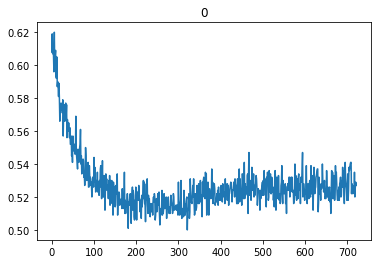

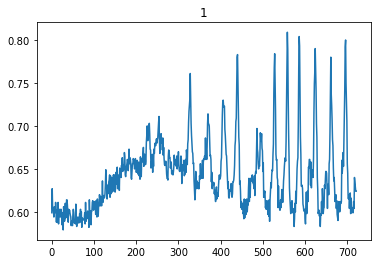

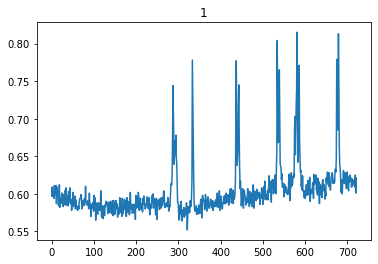

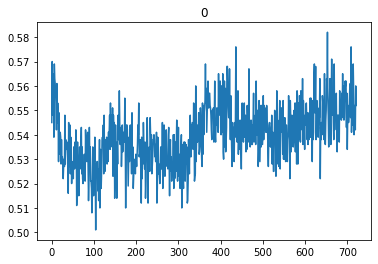

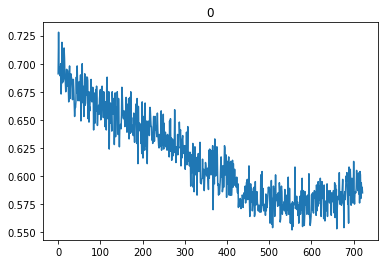

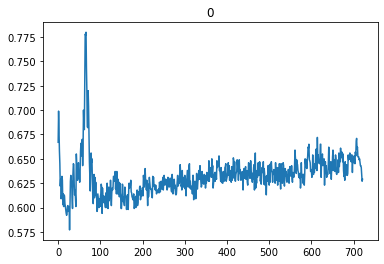

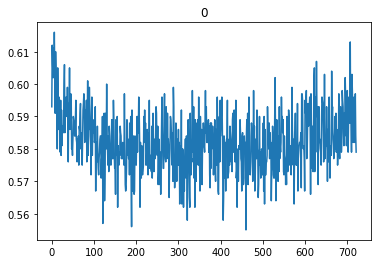

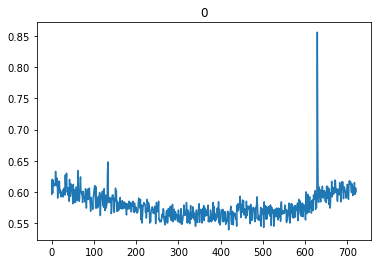

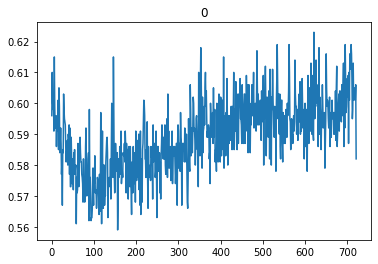

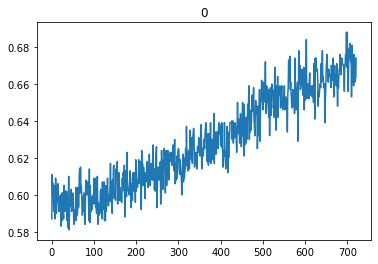

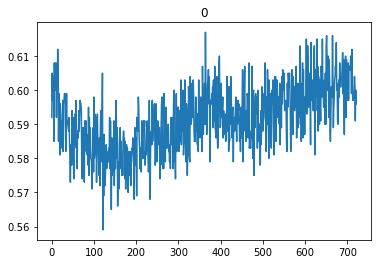

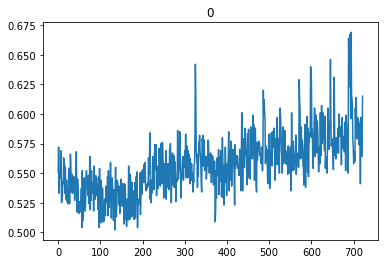

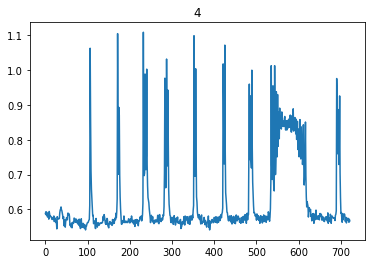

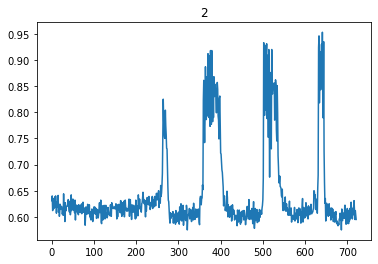

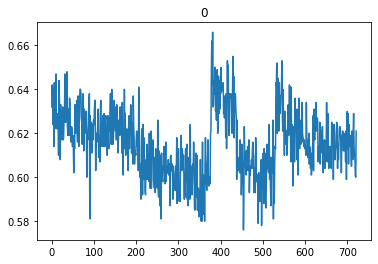

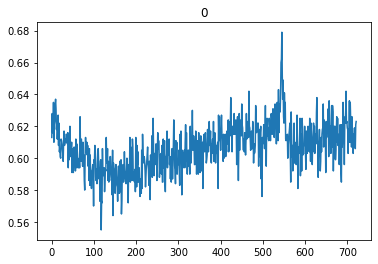

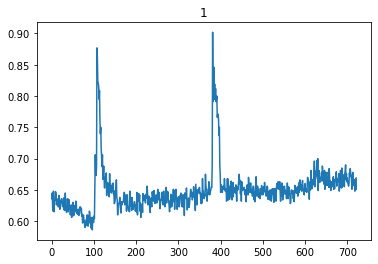

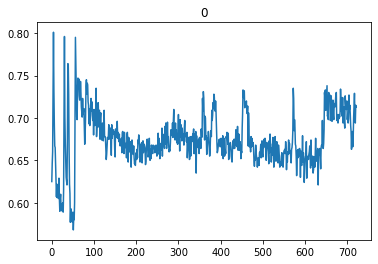

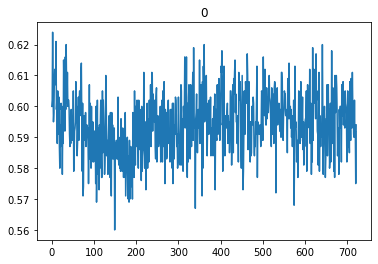

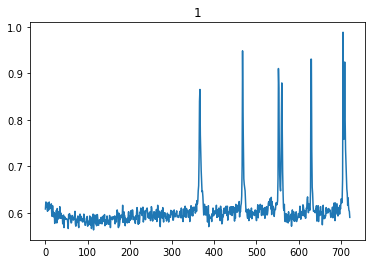

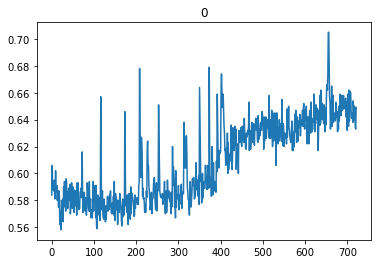

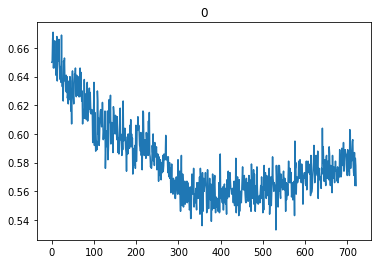

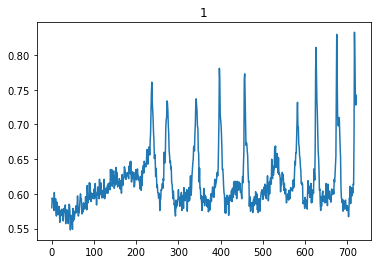

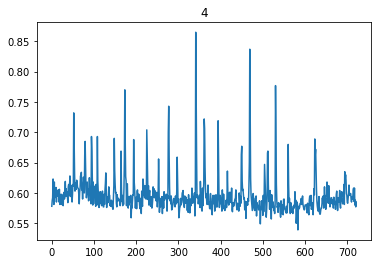

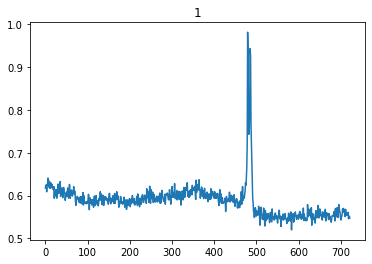

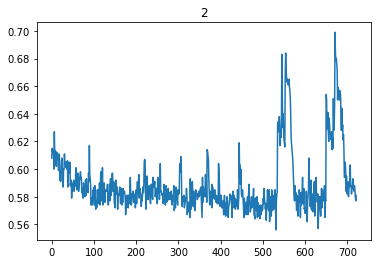

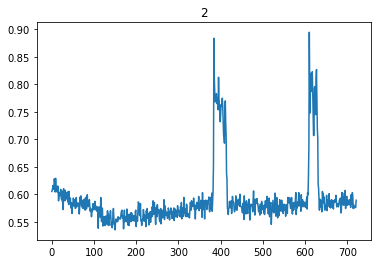

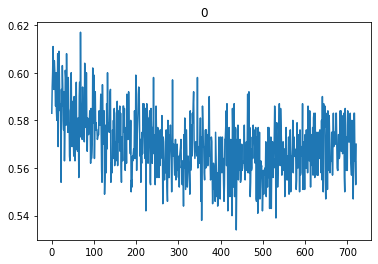

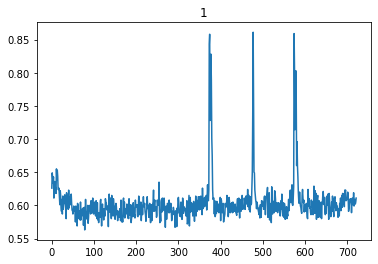

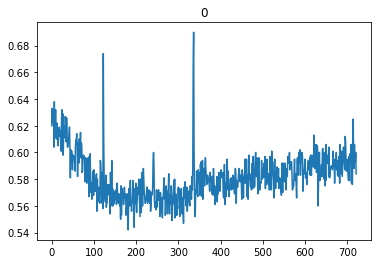

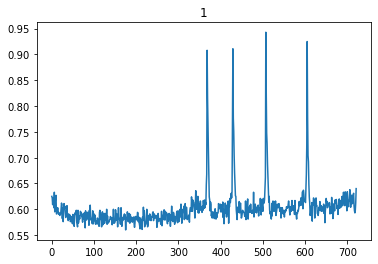

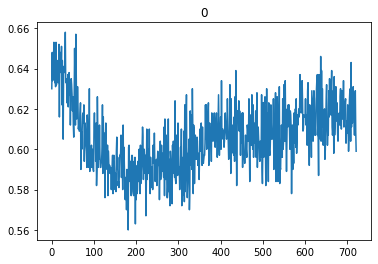

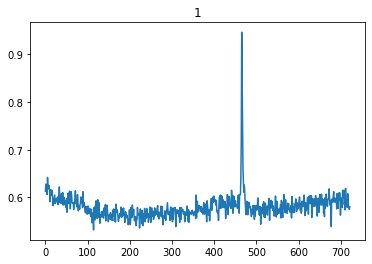

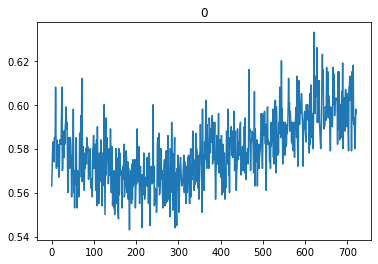

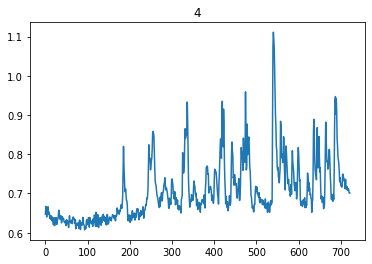

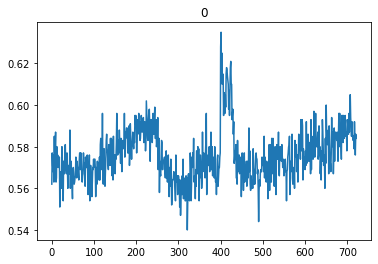

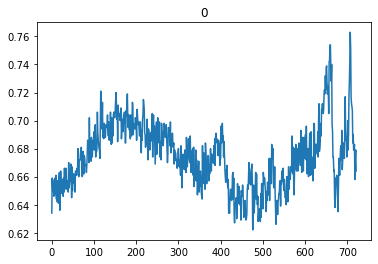

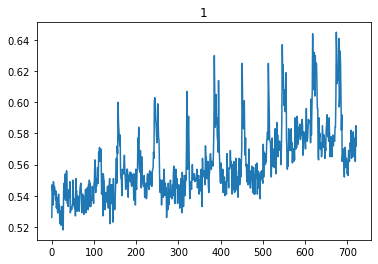

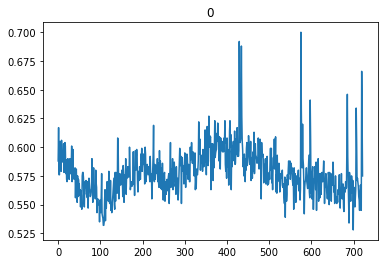

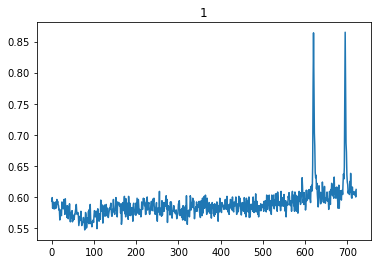

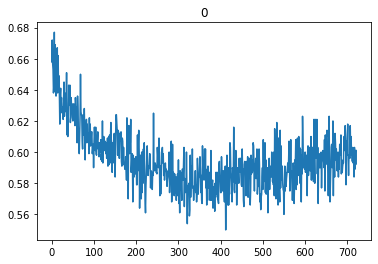

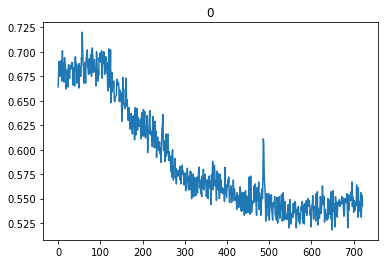

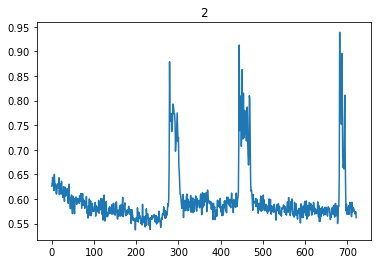

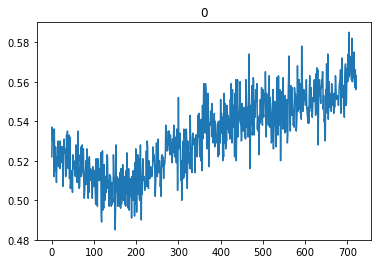

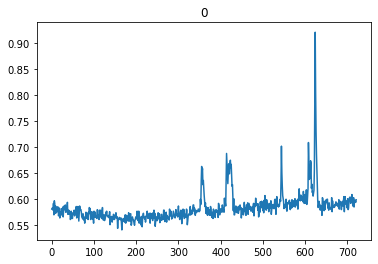

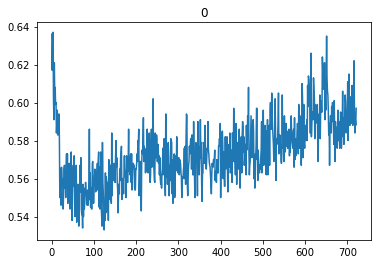

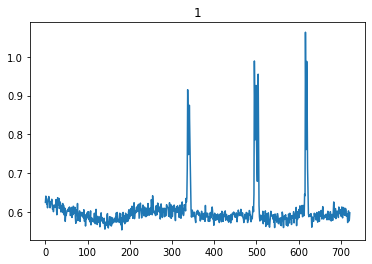

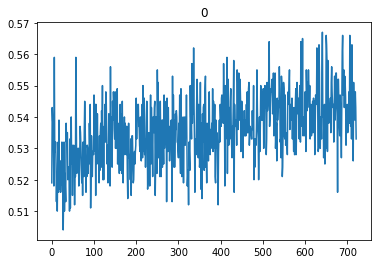

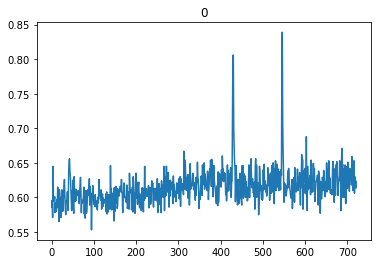

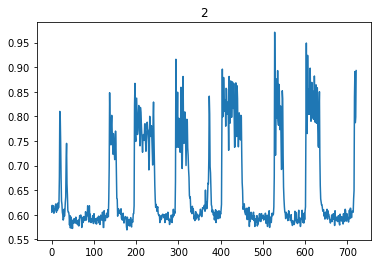

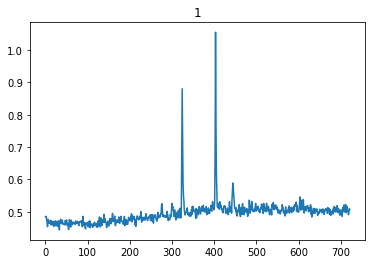

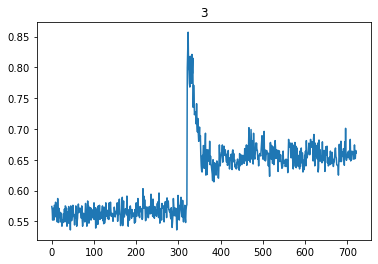

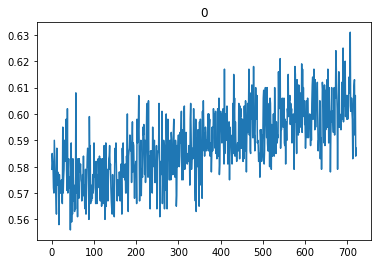

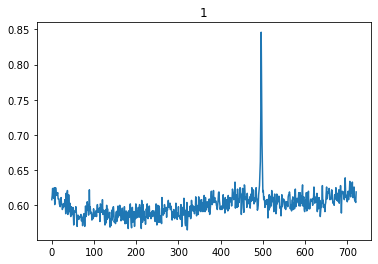

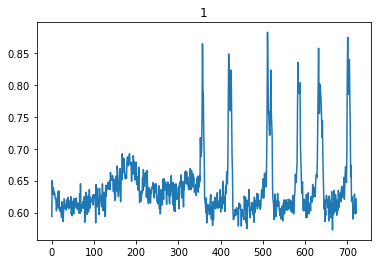

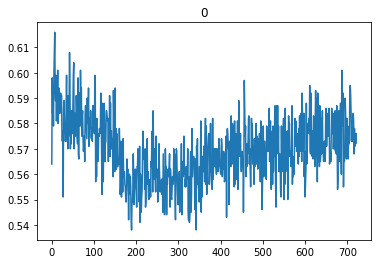

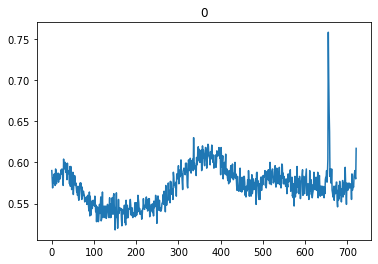

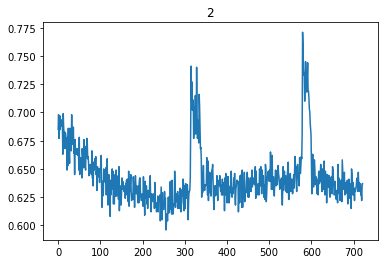

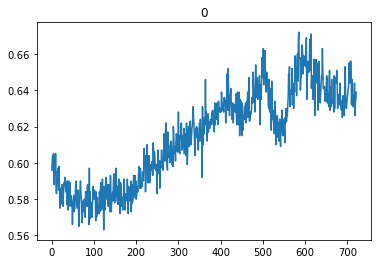

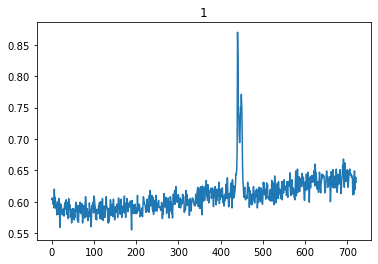

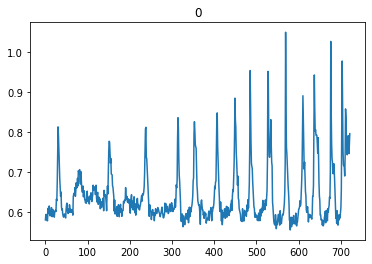

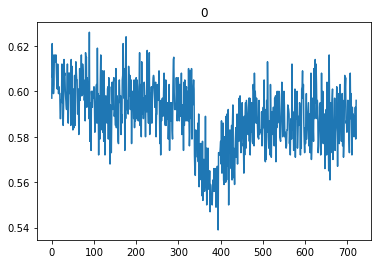

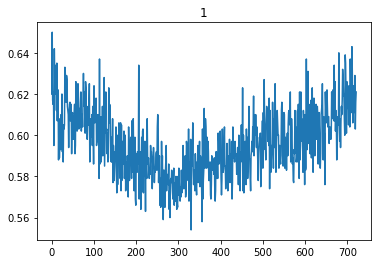

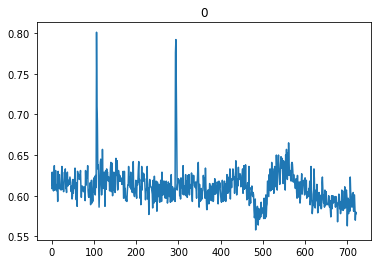

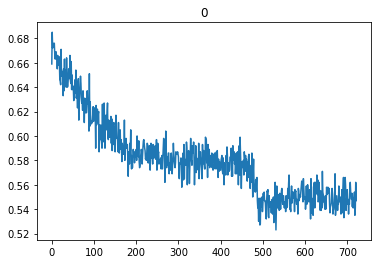

In [40]:
for row in range(len(df)):
    plt.plot(df.iloc[row].values[1:-2])
    plt.title(int(df.iloc[row]['label']))
    plt.show()

In [42]:
df[df['label'] == 3]

,ID,0:00:00,0:00:05,0:00:10,0:00:15,0:00:20,0:00:25,0:00:30,0:00:35,0:00:40,...,0:59:30,0:59:35,0:59:40,0:59:45,0:59:50,0:59:55,1:00:00,1:00:05,1:00:10,label
24,31,0.604,0.638,0.606,0.604,0.605,0.576,0.593,0.577,0.552,...,0.794,0.796,0.791,0.800,0.779,0.784,0.760,0.785,0.777,3
86,102,0.574,0.568,0.552,0.571,0.571,0.552,0.576,0.575,0.565,...,0.661,0.651,0.651,0.674,0.652,0.652,0.665,0.661,0.665,3


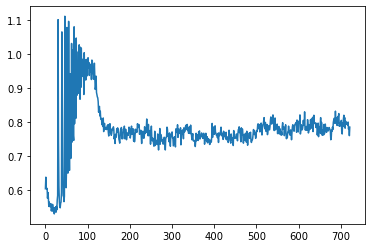

In [56]:
plt.plot(df[df['ID'] == 31].values[0][1:-2])

In [59]:
def plot_ma_spikes(roi_vals, ma_size=20, std_ratio=0.5, plot=True, return_=False):
    # this function will calculate and plot spikes found using the following definition:
    # spike begins when MA20 crosses 0.5 standard deviations above the cumulative moving average
    
    roi = roi_vals
    roi_ma = calc_ma(roi, size=ma_size)
    
    starts, ends, threshold = find_ma_spikes(roi, roi_ma, std_threshold=std_ratio)
    
    if plot:
        plt.figure(figsize=(10,5))
        plt.plot(roi)
        plt.plot(roi_ma, color='k')
        plt.plot(threshold, color='y')
        
        for i in range(len(starts)):
            plt.axvline(x=starts[i], color='goldenrod', linestyle='dashdot')
            plt.axvline(x=ends[i], color='goldenrod', linestyle='dashdot')
    
    if return_:
        return starts, ends, roi

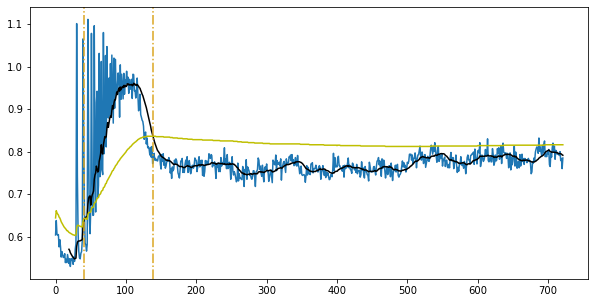

In [60]:
plot_ma_spikes(df[df['ID'] == 31].values[0][1:-2])

In [61]:
df[df['ID'] == 31].values[0][1:-2]

array([0.604, 0.638, 0.606, 0.604, 0.605, 0.576, 0.593, 0.577, 0.552,
       0.565, 0.557, 0.551, 0.552, 0.56 , 0.539, 0.547, 0.539, 0.558,
       0.548, 0.537, 0.548, 0.53 , 0.548, 0.544, 0.55 , 0.535, 0.552,
       0.542, 0.571, 0.584, 1.101, 0.744, 0.611, 0.566, 0.55 , 0.548,
       0.561, 0.565, 0.592, 1.065, 0.847, 0.669, 0.583, 0.582, 0.566,
       0.582, 1.111, 0.828, 0.641, 0.607, 0.664, 1.078, 0.755, 0.65 ,
       0.651, 1.096, 0.77 , 0.658, 0.915, 0.942, 0.693, 0.721, 1.031,
       0.741, 0.757, 1.012, 0.76 , 0.746, 1.08 , 0.795, 0.854, 1.026,
       0.811, 1.047, 0.905, 0.879, 0.973, 0.884, 1.007, 0.887, 1.027,
       0.948, 0.867, 1.02 , 0.902, 1.017, 0.943, 0.934, 0.961, 0.985,
       0.965, 0.881, 1.004, 0.923, 0.982, 0.951, 0.924, 0.984, 0.935,
       0.968, 0.961, 0.989, 0.96 , 0.975, 0.937, 0.97 , 0.947, 0.947,
       0.97 , 0.925, 0.982, 0.981, 0.943, 0.944, 0.926, 0.945, 0.973,
       0.934, 0.896, 0.903, 0.935, 0.887, 0.881, 0.874, 0.871, 0.86 ,
       0.829, 0.842,